'\nimport itertools\nstate = list(range(0,K))\ncombin = list(itertools.product(state,repeat=N))\n'

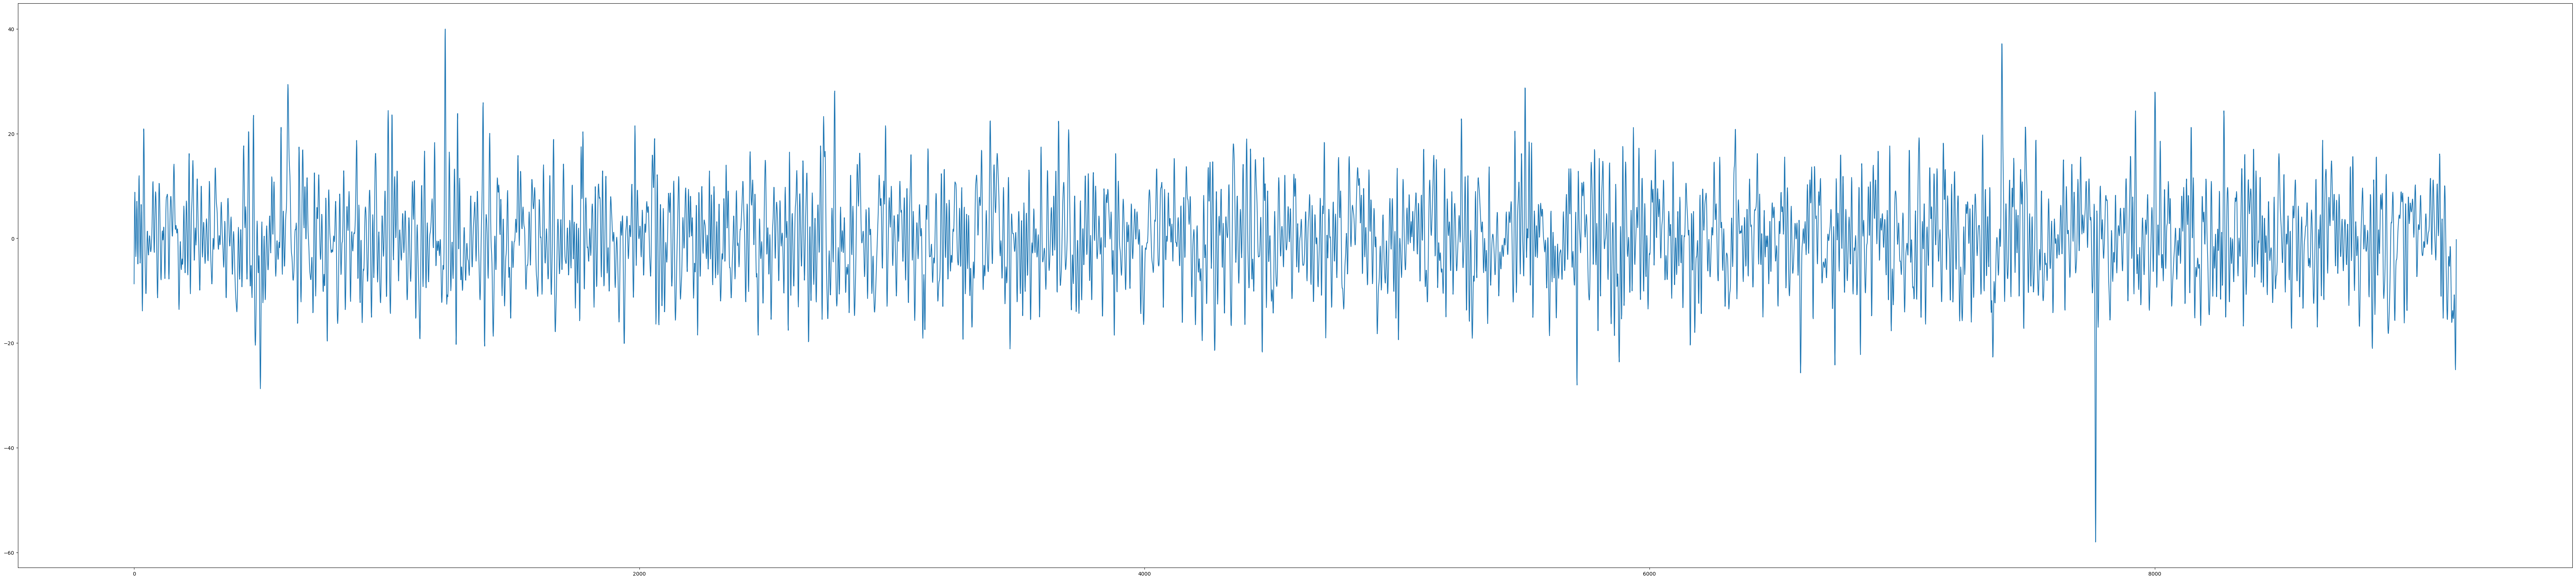

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import norm

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 5):
    from scipy.signal import butter, filtfilt
    #fs - sampling rate
    fa = 0.5 * fs
    low = lowcut/fa
    high = highcut/fa
    b,a = butter(order,[low, high], btype='band')
    y = filtfilt(b,a,data)
    return y

def draw_pic(data, long = 10, high = 10):
    x= data.shape[0]
    x_linspace = np.arange(0,x)
    #data = data - np.mean(data)
    plt.figure(figsize=(long,high))
    plt.plot(x_linspace,data)
    return

load_data = sio.loadmat('E:/study/Doctor/second_year/EEG_data/UCLA_data/times_CSC4.mat')
exp_data2 = load_data['spikes'].T[0]
filtered_signal = butter_bandpass_filter(exp_data2,100,6000,48000)
draw_pic(filtered_signal,90,20)

# The initial parameter seting
data = filtered_signal
N = 8
R = 1
K = 30
T = data.shape[0]
cov = np.cov(data)
std = np.std(data)
multi_P = np.ones(N) * 10**(-3) 

# the templet computation
mu_sr = 24 * 10 ** 3
lins = np.linspace(0,3 * np.pi , num = mu_sr)
sinmu = np.sin(lins)
mu_linspace = np.zeros((K,1))
for i in range(5,14):
    mu_linspace[i,0] = sinmu[int((i-5) * mu_sr / 10)]
h_multi_mu = np.random.uniform(0,5*std,N)
multi_mu = h_multi_mu * mu_linspace

"""
import itertools
state = list(range(0,K))
combin = list(itertools.product(state,repeat=N))
"""

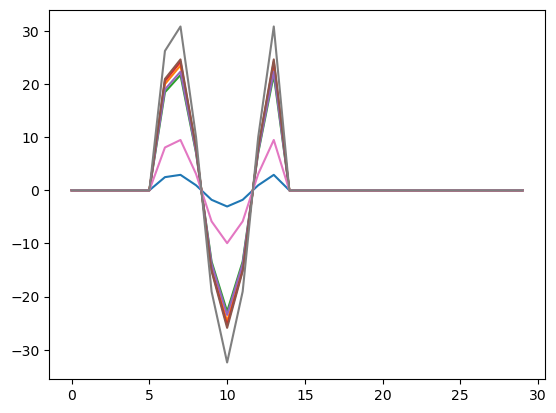

In [2]:
plt.plot(multi_mu)

In [3]:
from Baum_Welch_Algorithem import HMM_multi_spike
h = HMM_multi_spike(multi_mu,multi_P,cov)

In [4]:
h.baum_welch_train(data,R)

[1.3087372153848127e-11, 1.3087372153848127e-11, 1.3087372153848127e-11, 1.3087372153848127e-11, 1.3087372153848127e-11, 1.3087372153848127e-11, 1.3087372153848127e-11, 1.3087372153848127e-11]


E:\Python_code\EEGmodels\HMM-NRBFNN\Baum_Welch_Algorithem.py:378: RuntimeWarning: invalid value encountered in divide
  X[:,t] = X[:,t] / np.linalg.norm(X[:,t],ord=1)
E:\Python_code\EEGmodels\HMM-NRBFNN\Baum_Welch_Algorithem.py:450: RuntimeWarning: invalid value encountered in divide
  self.gamma = self.gamma / (np.linalg.norm(self.gamma,ord=1,axis=0))


LinAlgError: SVD did not converge

In [ ]:
from scipy.interpolate import CubicSpline
x = np.arange(len(h.mu))
y = h.mu
cs = CubicSpline(x,y)
xs = np.arange(0,len(h.mu),0.1)#在两个值中间加10个点来上采样
usmu = cs(xs)

In [ ]:
plt.plot(usmu)

In [ ]:
#result = h.stat_path(data)
#fine_path = list(result[1])
#plt.plot(fine_path)

In [ ]:
compare_s = usmu[:,0:2]
c21 = np.correlate(compare_s[:,0],compare_s[:,1],mode='full')
t21 = np.argmax(c21)
len_s = len(compare_s)
index = t21-len_s
if index > 0 :
    tt1 = compare_s[index:,1]
    tt2 = compare_s[0:index,1]
    compare_s[:,1] = np.append(tt1,tt2)
else:
    index = len_s + index
    tt1 = compare_s[0:index,1]
    tt2 = compare_s[index:,1]
    compare_s[:,1] = np.append(tt2,tt1)
compare_s = signal.resample(compare_s,K)
x12 = compare_s[0] - compare_s[1]
cc1 = np.cov(compare_s[0]) + np.cov(compare_s[1])
theta = np.dot(x12.T , x12) / cc1